In [1]:
# %%
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
from collections import deque
# Import the custom Model class
from Model import Model
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)
tf.random.set_seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG', 'DBC', 'VTI', '^VIX', 'VEA', 'EEM', 'VNQ', 'IWM']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252
# Define transaction cost rate
C = 0.0001  # 0.01%

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")

Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_43152\3919440199.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# %%
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2006-01-01', '2024-11-26')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")

[*********************100%%**********************]  8 of 8 completed


Data fetched successfully. Sample data:
Ticker            AGG        DBC        EEM        IWM        VEA        VNQ  \
Date                                                                           
2007-07-26  59.407745  23.019386  31.014328  61.926189  28.500334  32.133659   
2007-07-27  59.347595  23.240469  30.612547  60.420193  28.065977  31.067533   
2007-07-30  59.317562  22.975168  31.614662  61.468853  28.536026  31.668449   
2007-07-31  59.503910  23.160881  30.967598  60.790810  28.500334  31.542437   
2007-08-01  59.365662  23.125507  30.846138  61.121941  28.619322  31.959187   

Ticker            VTI       ^VIX  
Date                              
2007-07-26  53.209694  20.740000  
2007-07-27  52.208805  24.170000  
2007-07-30  52.981232  20.870001  
2007-07-31  52.255962  23.520000  
2007-08-01  52.564209  23.670000  
Data covers 4365 trading days with 8 assets.


In [3]:
# %%
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating window-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       EEM       IWM       VEA       VNQ  \
Date                                                                     
2007-10-04  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2007-10-05  1.000263  1.001310  1.003596  1.001472  1.001354  1.003240   
2007-10-08  1.000705  1.001988  1.007200  1.003269  1.002808  1.006693   
2007-10-09  1.001113  1.003039  1.010527  1.004901  1.004195  1.010032   
2007-10-10  1.001487  1.004174  1.014295  1.006733  1.005544  1.013292   

Ticker           VTI      ^VIX  
Date                            
2007-10-04  1.000000  1.000000  
2007-10-05  1.001164  0.996699  
2007-10-08  1.002676  0.990916  
2007-10-09  1.004046  0.986822  
2007-10-10  1.005647  0.980918  

Sample daily returns:
Ticker           AGG       DBC       EEM       IWM       VEA       VNQ  \
Date                                                                     
2007-10-05  0.000268  0.00

In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, asset_names: List[str], transaction_cost: float = 0.0001):
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.transaction_cost_rate = transaction_cost
        self.asset_names = asset_names
        self.current_weights = np.zeros(len(asset_names))
        self.portfolio_values = []
        self.weights_history = []
        self.dates = []
        self.transaction_cost = 0.0  # Initialize transaction cost

    def rebalance(self, new_weights: np.array):
        # Compute transaction costs
        if len(self.weights_history) == 0:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights))
        else:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights - self.current_weights))
        self.transaction_cost = transaction_cost * self.current_value
        self.current_weights = new_weights.copy()
        self.weights_history.append(self.current_weights.copy())

    def update_portfolio_value(self, asset_returns: np.array, current_date: pd.Timestamp):
        # Compute portfolio return
        portfolio_return = np.dot(self.current_weights, asset_returns)
        self.current_value = self.current_value * (1 + portfolio_return) - self.transaction_cost
        self.transaction_cost = 0.0
        self.portfolio_values.append(self.current_value)
        self.dates.append(current_date)
    
    def get_portfolio_values(self):
        return self.portfolio_values


In [5]:
# %%
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing various performance metrics.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Number of days
    N = len(portfolio_returns)

    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns) if len(downside_returns) > 0 else 0
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR) if downside_std_dev != 0 else np.nan
    
    # Calculate Maximum Drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = np.max(drawdowns)
    
    # Expected return (annualized)
    cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (TRADING_DAYS_PER_YEAR / N) - 1

    # Standard deviation of returns (annualized)
    annualized_std = std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Percentage of positive returns
    positive_returns = portfolio_returns[portfolio_returns > 0]
    percentage_positive = len(positive_returns) / len(portfolio_returns) * 100

    # Average profit / average loss (profit/loss ratio)
    average_profit = np.mean(portfolio_returns[portfolio_returns > 0]) if len(positive_returns) > 0 else 0
    average_loss = np.mean(portfolio_returns[portfolio_returns < 0]) if len(portfolio_returns[portfolio_returns < 0]) > 0 else 0
    profit_loss_ratio = (average_profit / -average_loss) if average_loss != 0 else np.nan

    metrics = {
        "Annualized Return": annualized_return,
        "Annualized Std Dev": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "% Positive Returns": percentage_positive,
        "Profit/Loss Ratio": profit_loss_ratio
    }
    
    return metrics


In [6]:
# %%
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

# Define function to get MV weights
def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

# Define function to get MD weights
def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [7]:
def average_metrics(metrics_list):
    """
    Calculates the average of each metric in the list of metrics.
    """
    avg_metrics = {}
    keys = metrics_list[0].keys()
    for key in keys:
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    return avg_metrics


In [8]:
def plot_performance_comparison(portfolio_histories, periods, strategies):
    """
    Plots the actual portfolio values for each strategy across all testing periods in a grid format,
    swapping rows and columns such that rows represent strategies and columns represent periods.
    
    Parameters:
    - portfolio_histories: Dictionary containing portfolio value histories for each strategy.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Performance Comparison (Raw Values)', fontsize=16, y=0.92)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            # Handle axes indexing for single row or column
            if num_periods == 1 and num_strategies == 1:
                ax = axes
            elif num_periods == 1:
                ax = axes[strat_idx]
            elif num_strategies == 1:
                ax = axes[period_idx]
            else:
                ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            values = history['values']
            # Plot raw portfolio values
            ax.plot(dates, values, label=f"{strategy}")
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Portfolio Value ($)')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [9]:
def plot_weights_comparison(portfolio_histories, periods, strategies, asset_names):
    """
    Plots the portfolio weights for each strategy across all testing periods in a grid format,
    with each asset having its own line on the graph, colored differently and with a legend.

    Parameters:
    - portfolio_histories: Dictionary containing portfolio histories for each strategy.
      Each entry should have 'dates', 'values', and 'weights'.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    - asset_names: List of asset names corresponding to portfolio weights.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Weights Comparison', fontsize=16, y=0.92)
    
    # If there's only one strategy or one period, adjust axes accordingly
    if num_strategies == 1 and num_periods == 1:
        axes = np.array([[axes]])
    elif num_strategies == 1:
        axes = np.expand_dims(axes, axis=0)
    elif num_periods == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            weights = np.array(history['weights'])  # Shape: (num_days, num_assets)
            
            # Create a DataFrame for easier plotting
            weights_df = pd.DataFrame(weights, index=dates, columns=asset_names)
            
            # Plot each asset's weight over time
            for asset in asset_names:
                ax.plot(weights_df.index, weights_df[asset], label=asset)
            
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Weight')
            ax.legend(fontsize='small', ncol=2)
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [10]:
# %%
# Define testing periods
training_end_dates = ['2010-12-31', '2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31','2020-12-31','2022-12-31']
testing_start_dates = ['2011-01-01', '2013-01-01', '2015-01-01', '2017-01-01', '2019-01-01','2021-01-01','2023-01-01']
testing_end_dates = ['2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31', '2020-12-31','2022-12-31','2024-11-25']

periods = list(zip(training_end_dates, testing_start_dates, testing_end_dates))

# Initialize lists to store performance metrics for each model
lstm_metrics = []
mvo_metrics = []
md_metrics = []
ew_metrics = []
# Initialize a dictionary to store portfolio histories for each strategy
portfolio_histories = {
    'LSTM': [],
    'MVO': [],
    'MD': [],
    'EW': []
}

initial_cash = 100000

In [11]:
for period in periods:
    training_end, testing_start, testing_end = period
    print(f"\nProcessing period: Training up to {training_end}, Testing from {testing_start} to {testing_end}")

    # Split the data into training and testing sets
    training_data = data.loc[:training_end].copy()
    testing_data = data.loc[testing_start:testing_end].copy()
    testing_returns = testing_data.pct_change().fillna(0)

    # Ensure there is enough data for testing
    if len(testing_data) < 1:
        print("Not enough data for testing period")
        continue

    # Initialize and train the LSTM model
    lstm_model = Model()
    lstm_model.train(training_data)

    # Initialize the portfolio for LSTM strategy
    portfolio_lstm = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )

    # Define the rolling window size
    window_size = 50

    # Combine the last 'window_size' days of training data with the testing data
    combined_data = pd.concat(
        [training_data.tail(window_size), testing_data],
        ignore_index=False
    )

    # Iterate over each day in the testing period
    for i, current_date in enumerate(testing_data.index):
        # Calculate the end index for the input sequence
        end_idx = window_size + i

        # Extract the input sequence: the preceding 'window_size' days
        input_sequence = combined_data.iloc[end_idx - window_size:end_idx]

        # Calculate the returns for the input sequence
        returns_sequence = input_sequence.pct_change().fillna(0)

        # Combine price and return data for model input
        combined_sequence = pd.concat([input_sequence, returns_sequence], axis=1).values

        # Predict the allocation using the LSTM model
        allocation = lstm_model.predict_allocation(combined_sequence)

        # Rebalance the portfolio with the new allocation
        portfolio_lstm.rebalance(allocation)

        # Get today's return
        today_return = testing_returns.iloc[i].values

        # Update the portfolio value based on today's return
        portfolio_lstm.update_portfolio_value(today_return, current_date)

    # Store the LSTM portfolio history
    portfolio_values_lstm = portfolio_lstm.get_portfolio_values()
    portfolio_dates_lstm = portfolio_lstm.dates
    portfolio_histories['LSTM'].append({
        'dates': portfolio_dates_lstm,
        'values': portfolio_values_lstm,
        'weights': portfolio_lstm.weights_history
    })

    # Calculate and store performance metrics for LSTM
    metrics_lstm = calculate_metrics(portfolio_values_lstm)
    lstm_metrics.append(metrics_lstm)

    # -------------------------------------------
    # Mean-Variance Optimization (MVO) Model
    # -------------------------------------------

    # Calculate full testing period returns
    returns_full_testing = data.loc[:testing_end].pct_change().dropna()
    returns_testing = data.loc[testing_start:testing_end].pct_change().dropna()

    # Get indices of testing dates in returns
    testing_indices = returns_full_testing.index.get_indexer_for(returns_testing.index)

    # Initialize the portfolio for MVO strategy
    portfolio_mv = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )

    for i in range(window_size, len(testing_indices)):
        # Extract the past 'window_size' days of returns
        input_data = returns_full_testing.iloc[i - window_size:i]
        weights_mv = mean_variance_optimized_strategy(input_data)

        print("MVO Allocation:", weights_mv)

        # Rebalance the portfolio with MVO weights
        portfolio_mv.rebalance(weights_mv)

        # Get today's return
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]

        # Update portfolio value
        portfolio_mv.update_portfolio_value(today_return, current_date)

    # Store MVO portfolio history
    portfolio_values_mv = portfolio_mv.get_portfolio_values()
    portfolio_dates_mv = portfolio_mv.dates
    portfolio_histories['MVO'].append({
        'dates': portfolio_dates_mv,
        'values': portfolio_values_mv,
        'weights': portfolio_mv.weights_history
    })

    # Calculate and store performance metrics for MVO
    metrics_mv = calculate_metrics(portfolio_values_mv)
    mvo_metrics.append(metrics_mv)

    # -------------------------------------------
    # Maximum Diversification (MD) Model
    # -------------------------------------------

    # Initialize the portfolio for MD strategy
    portfolio_md = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )

    for i in range(window_size, len(testing_indices)):
        # Extract the past 'window_size' days of returns
        input_data = returns_full_testing.iloc[i - window_size:i]
        weights_md = maximum_diversification(input_data)

        print("MD Allocation:", weights_md)

        # Rebalance the portfolio with MD weights
        portfolio_md.rebalance(weights_md)

        # Get today's return
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]

        # Update portfolio value
        portfolio_md.update_portfolio_value(today_return, current_date)

    # Store MD portfolio history
    portfolio_values_md = portfolio_md.get_portfolio_values()
    portfolio_dates_md = portfolio_md.dates
    portfolio_histories['MD'].append({
        'dates': portfolio_dates_md,
        'values': portfolio_values_md,
        'weights': portfolio_md.weights_history
    })

    # Calculate and store performance metrics for MD
    metrics_md = calculate_metrics(portfolio_values_md)
    md_metrics.append(metrics_md)

    # -------------------------------------------
    # Equal Weighted (EW) Strategy
    # -------------------------------------------

    # Initialize the portfolio for EW strategy
    portfolio_ew = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )
    weights_ew = equal_weighted_strategy(returns_full_testing)

    for i in range(len(testing_indices)):
        today_return = testing_returns.iloc[i].values
        current_date = testing_returns.index[i]
        if i % 252 == 0:
            # Rebalance every year
            portfolio_ew.rebalance(weights_ew)

        portfolio_ew.update_portfolio_value(today_return, current_date)

    # Store EW portfolio history
    portfolio_values_ew = portfolio_ew.get_portfolio_values()
    portfolio_dates_ew = portfolio_ew.dates
    portfolio_histories['EW'].append({
        'dates': portfolio_dates_ew,
        'values': portfolio_values_ew,
        'weights': portfolio_ew.weights_history
    })

    # Calculate and store performance metrics for EW
    metrics_ew = calculate_metrics(portfolio_values_ew)
    ew_metrics.append(metrics_ew)



Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31
Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: -0.0168
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.0493
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0594
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0654
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0791
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.0881
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.1011
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.1134
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.1210
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.1239
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1320
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.1372
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: -0.1408
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1379
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0765
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1173
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1180
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.1258
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1282
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1348
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.1402
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1476
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1602
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1560
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1613
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1665
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1730
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1721
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0248
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0624
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0726
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0769
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0784
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0873
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0846
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0982
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: -0.1035
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: -0.1136
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: -0.1212
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: -0.1190
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: -0.1275
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -0.1299
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.0575
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0749
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0915
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1014
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1151
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1277
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1389
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1458
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1512
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1530
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1564
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1614
Epoch 13/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1652
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1627
Epoch 15/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -0.0301
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0634
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0804
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0925
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1128
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1224
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1311
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1359
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1392
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1411
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1440
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1475
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1508
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1520
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -0.0419
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0737
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0837
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0912
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1105
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1156
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1281
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1351
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1397
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1424
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1450
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1467
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1493
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1481
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0340
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0627
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0722
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0804
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0832
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1090
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1132
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1203
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1170
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1234
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1356
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1344
Epoch 13/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1381
Epoch 14/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1417
Epoch 15/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - 

In [12]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)

In [13]:
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")


Average Metrics for LSTM Model:
Annualized Return: 0.1744
Annualized Std Dev: 0.1076
Sharpe Ratio: 1.7078
Sortino Ratio: 3.1557
Max Drawdown: 0.0903
% Positive Returns: 52.3696
Profit/Loss Ratio: 1.2942

Average Metrics for MVO Strategy:
Annualized Return: 0.0539
Annualized Std Dev: 0.2028
Sharpe Ratio: 0.3484
Sortino Ratio: 0.5199
Max Drawdown: 0.2245
% Positive Returns: 50.7257
Profit/Loss Ratio: 1.0662

Average Metrics for MD Strategy:
Annualized Return: 0.1749
Annualized Std Dev: 0.1407
Sharpe Ratio: 1.1834
Sortino Ratio: 2.0692
Max Drawdown: 0.0891
% Positive Returns: 50.6601
Profit/Loss Ratio: 1.2574

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.1660
Annualized Std Dev: 0.1158
Sharpe Ratio: 1.3691
Sortino Ratio: 2.5304
Max Drawdown: 0.0797
% Positive Returns: 51.1243
Profit/Loss Ratio: 1.2336


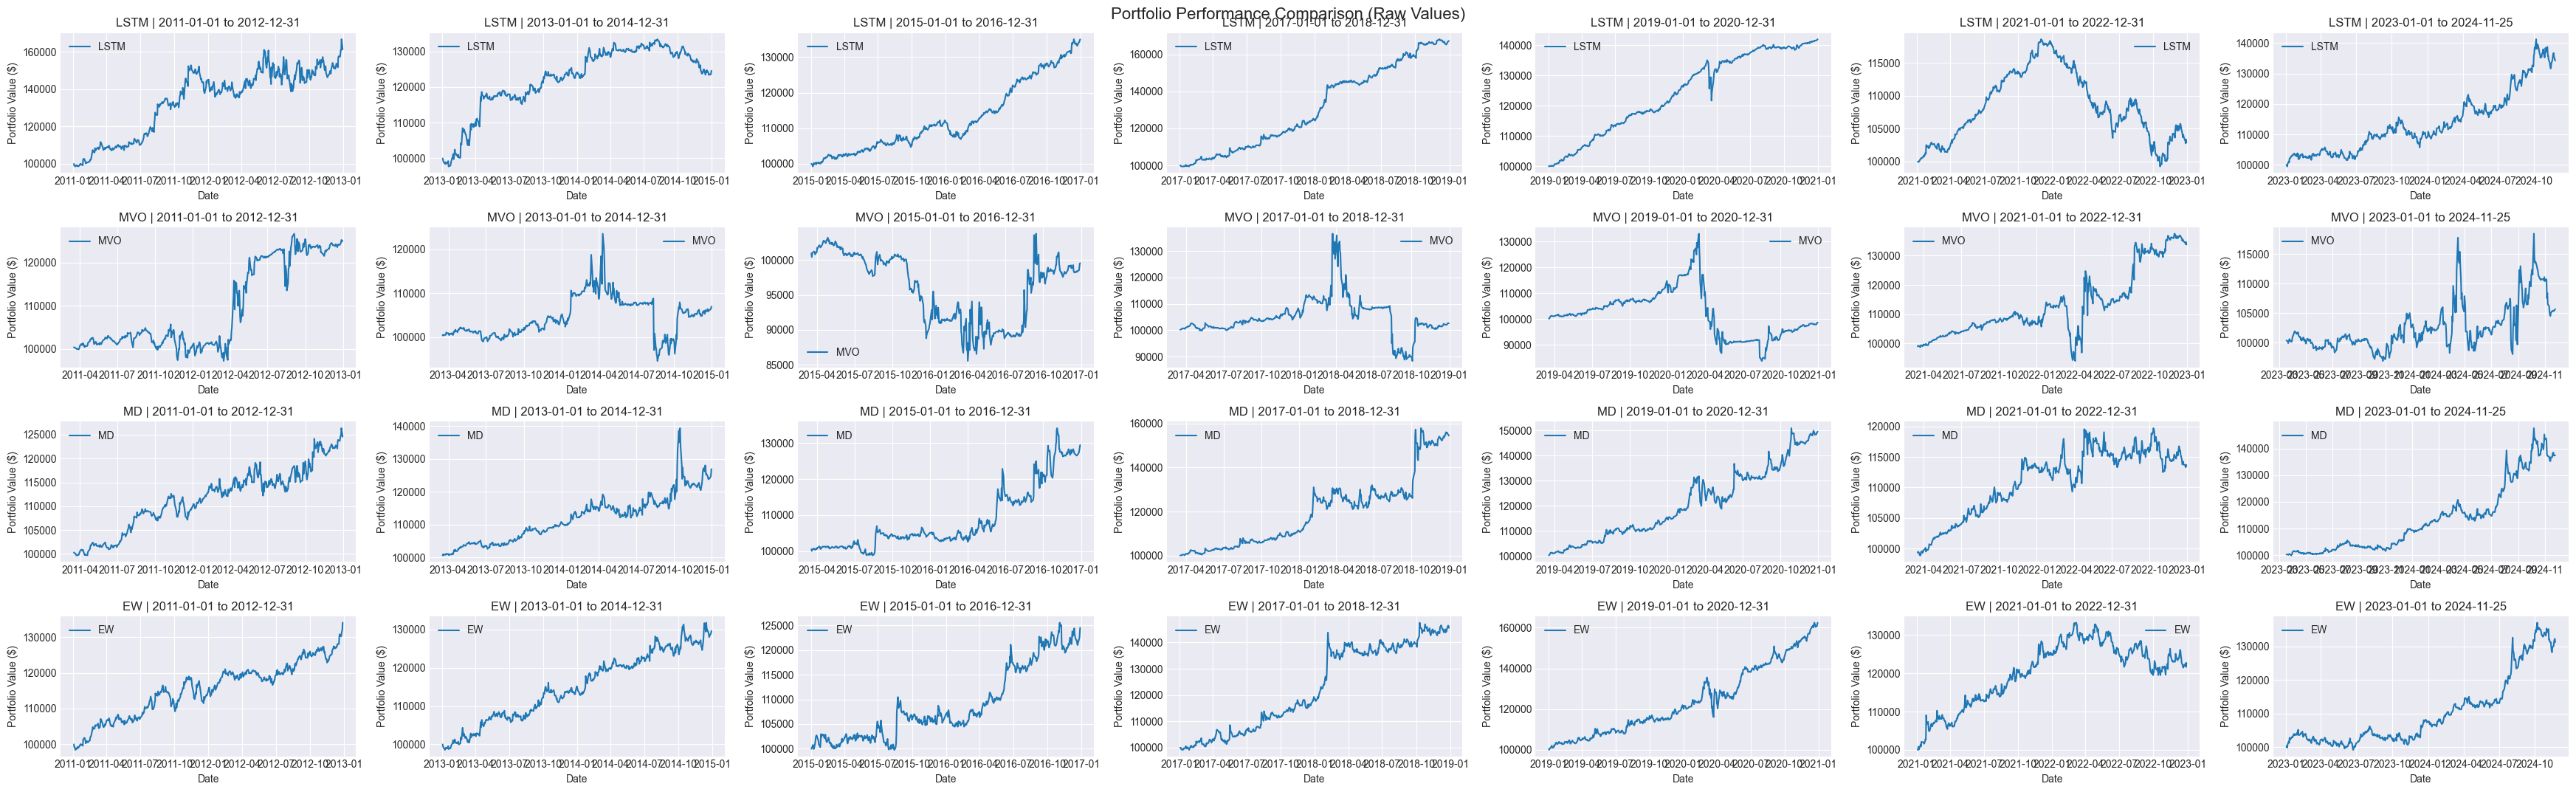

In [14]:
strategies = ['LSTM', 'MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)

ValueError: Shape of passed values is (502, 8), indices imply (502, 4)

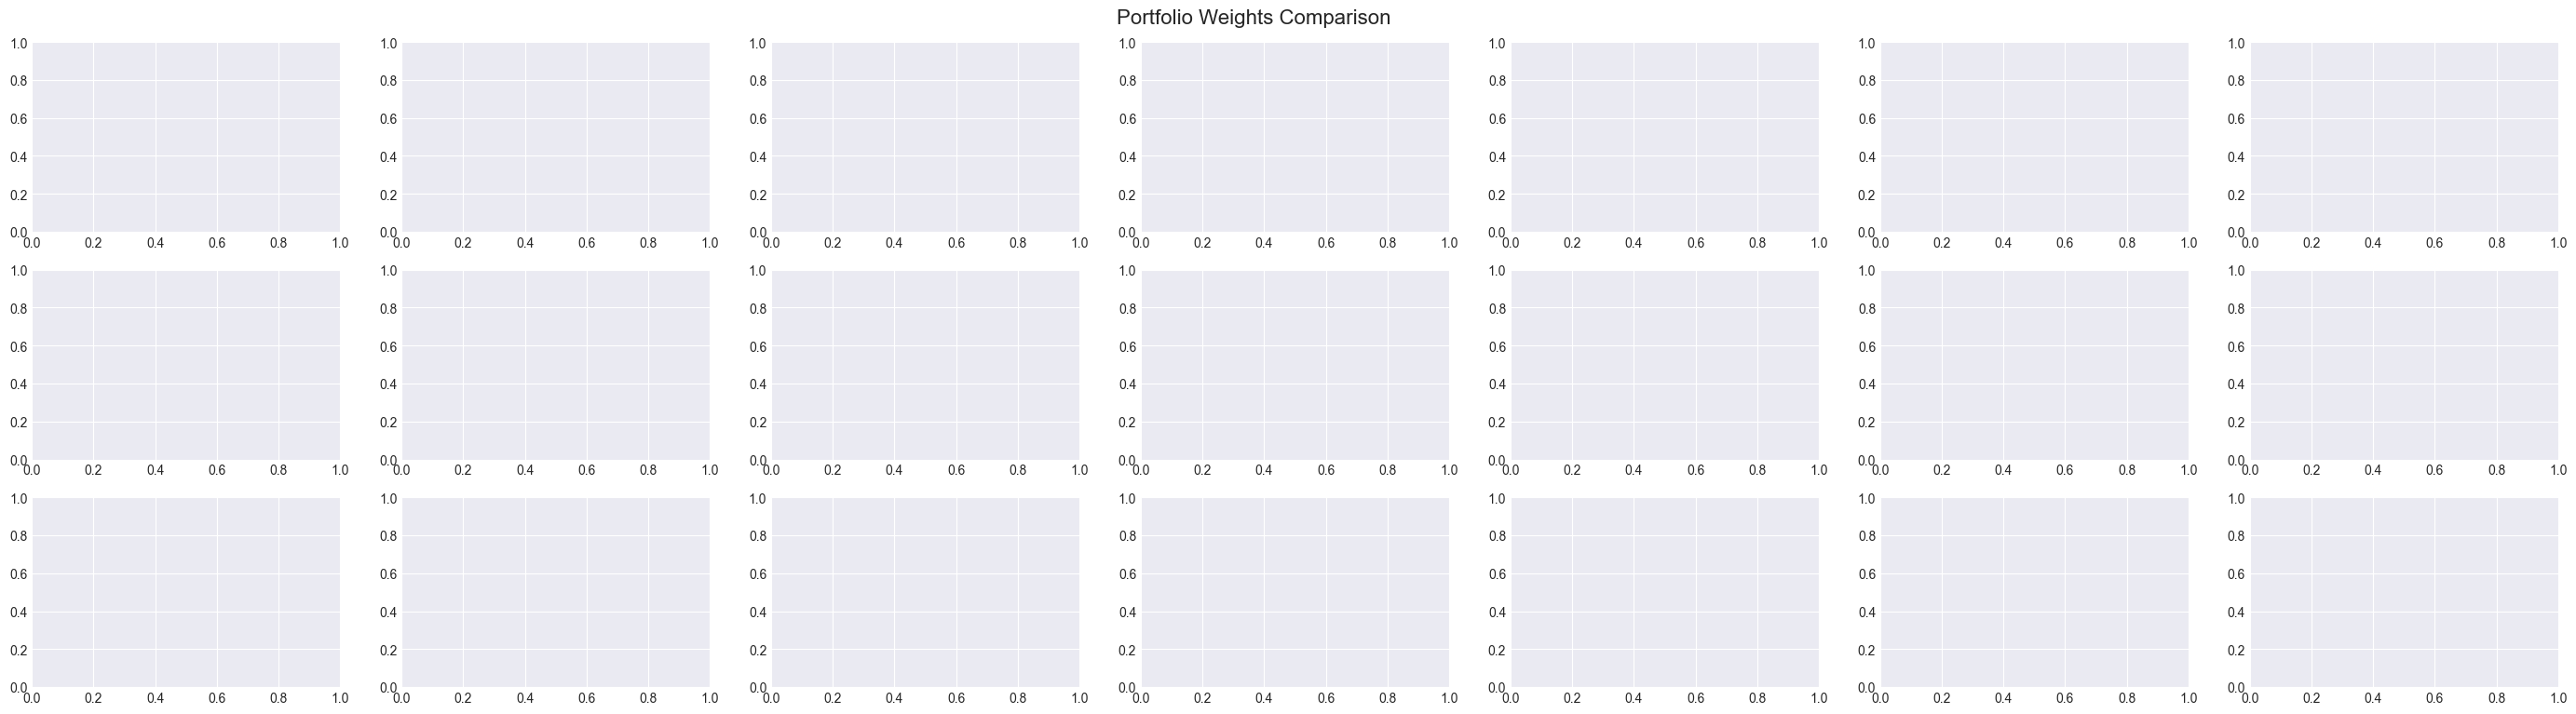

In [ ]:
strategies = ['LSTM', 'MVO', 'MD']
asset_names = ['AGG', 'DBC', 'VTI', '^VIX', 'VEA', 'EEM', 'VNQ', 'IWM']
plot_weights_comparison(portfolio_histories, periods, strategies, asset_names)